# Bidirectional LSTM (Right Wrist)

##### https://www.kaggle.com/malekzadeh/human-activity-recognition-with-mobile-sensing

##### https://github.com/akhuperkar/HAR-Smartphone-Accelerometer/blob/master/HAR%20Using%20Machine%20Learning%20.ipynb

#### Import Libraries

In [124]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats
import math
#from scipy.fftpack import fft
#from scipy.signal import welch

#from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
#import pywt

from scipy import stats
import seaborn as sns
from tensorflow import keras

In [125]:
#import time
#import datetime as dt
from collections import defaultdict, Counter

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

import warnings
warnings.filterwarnings("ignore")

#from detecta import detect_peaks

In [126]:
df = pd.read_csv('acc_data_right_wrist.csv')
df = df.drop([0])

In [127]:
print(df)

     PacketCounter  SampleTimeFine     Acc_X     Acc_Y     Acc_Z Unnamed: 11
1                1      1255232210 -8.874124 -0.679627  2.768368            
2                2      1255248877 -8.873473 -0.613973  2.761706            
3                3      1255265544 -8.834931 -0.518206  2.797576            
4                4      1255282211 -8.921975 -0.508252  2.836315            
5                5      1255298878 -8.999269 -0.533706  2.816627            
..             ...             ...       ...       ...       ...         ...
398            398      1261849009 -8.989089 -2.510464  2.123948            
399            399      1261865676 -9.029768 -2.650938  2.112896            
400            400      1261882343 -9.044131 -2.731521  2.112670            
401            401      1261899010 -8.995914 -2.801886  2.085057            
402            402      1261915677 -8.966281 -2.829942  2.044567            

[402 rows x 6 columns]


In [128]:
df2 = pd.read_csv('acc_data_right_wrist_label.csv')
df2 = df2.drop([0])
print(df2)

     PacketCounter  SampleTimeFine  Label  Unnamed: 3  Unnamed: 4 Unnamed: 5
1                1      1255232210      1         NaN         NaN           
2                2      1255248877      1         NaN         NaN           
3                3      1255265544      1         NaN         NaN           
4                4      1255282211      1         NaN         NaN           
5                5      1255298878      1         NaN         NaN           
..             ...             ...    ...         ...         ...        ...
398            398      1261849009      3         NaN         NaN           
399            399      1261865676      3         NaN         NaN           
400            400      1261882343      3         NaN         NaN           
401            401      1261899010      3         NaN         NaN           
402            402      1261915677      3         NaN         NaN           

[402 rows x 6 columns]


In [129]:
df_train = df
label_train = df2
print("Shape of original data:", df_train.shape)
print("Shape of labels data:", label_train.shape)

Shape of original data: (402, 6)
Shape of labels data: (402, 6)


In [130]:
print(df_train.head())

   PacketCounter  SampleTimeFine     Acc_X     Acc_Y     Acc_Z Unnamed: 11
1              1      1255232210 -8.874124 -0.679627  2.768368            
2              2      1255248877 -8.873473 -0.613973  2.761706            
3              3      1255265544 -8.834931 -0.518206  2.797576            
4              4      1255282211 -8.921975 -0.508252  2.836315            
5              5      1255298878 -8.999269 -0.533706  2.816627            


In [131]:
def magnitude(activity):
    x2 = activity['Acc_X'] * activity['Acc_X']
    y2 = activity['Acc_Y'] * activity['Acc_Y']
    z2 = activity['Acc_Z'] * activity['Acc_Z']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

df_train['m'] = magnitude(df_train)
df_train.head()

,PacketCounter,SampleTimeFine,Acc_X,Acc_Y,Acc_Z,Unnamed: 11,m
1,1,1255232210,-8.874124,-0.679627,2.768368,,9.320720
2,2,1255248877,-8.873473,-0.613973,2.761706,,9.313566
3,3,1255265544,-8.834931,-0.518206,2.797576,,9.281755
4,4,1255282211,-8.921975,-0.508252,2.836315,,9.375748
5,5,1255298878,-8.999269,-0.533706,2.816627,,9.444844


In [132]:
print(label_train.head())

   PacketCounter  SampleTimeFine  Label  Unnamed: 3  Unnamed: 4 Unnamed: 5
1              1      1255232210      1         NaN         NaN           
2              2      1255248877      1         NaN         NaN           
3              3      1255265544      1         NaN         NaN           
4              4      1255282211      1         NaN         NaN           
5              5      1255298878      1         NaN         NaN           


In [133]:
pd.DataFrame.from_dict(Counter(label_train['Label']), orient="Index", columns=['label']).reset_index()

,index,label
0,1,120
1,2,128
2,3,154


#### Plot Acceleration Data

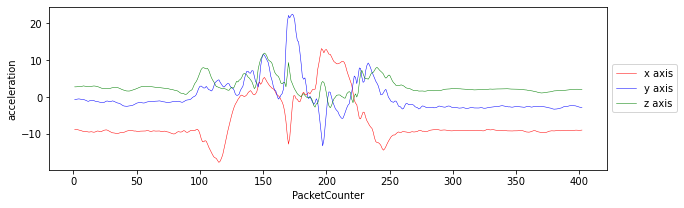

In [134]:
plt.figure(figsize=(10,3))
plt.plot(df_train['PacketCounter'], df_train['Acc_X'], linewidth=0.5, color='r', label='x axis')
plt.plot(df_train['PacketCounter'], df_train['Acc_Y'], linewidth=0.5, color='b', label='y axis')
plt.plot(df_train['PacketCounter'], df_train['Acc_Z'], linewidth=0.5, color='g', label='z axis')
plt.xlabel('PacketCounter')
plt.ylabel('acceleration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

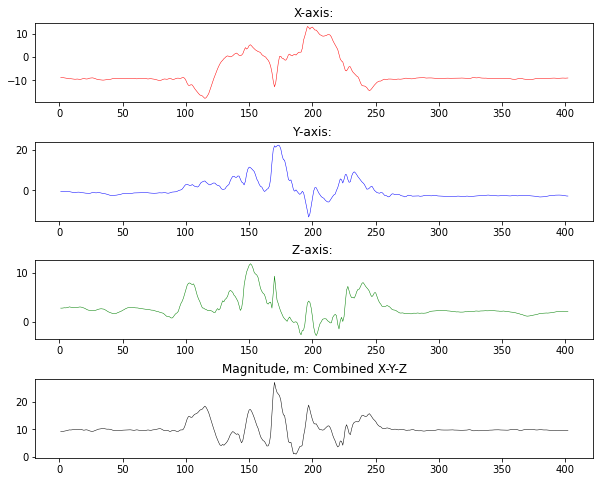

In [135]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

ax[0].set_title('X-axis:')
ax[0].plot(df_train['PacketCounter'], df_train['Acc_X'], linewidth=0.5, color='r')

ax[1].set_title('Y-axis: ')
ax[1].plot(df_train['PacketCounter'], df_train['Acc_Y'], linewidth=0.5, color='b')

ax[2].set_title('Z-axis: ')
ax[2].plot(df_train['PacketCounter'], df_train['Acc_Z'], linewidth=0.5, color='g')

ax[3].set_title('Magnitude, m: Combined X-Y-Z')
ax[3].plot(df_train['PacketCounter'], df_train['m'], linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

In [136]:
# Separating data for each activity
train_df = pd.concat([df_train, label_train['Label']], axis=1).dropna()
columns = ['PacketCounter', 'Acc_X', 'Acc_Y', 'Acc_Z', 'm', 'Label']

idle = train_df[columns][train_df.Label == 1]
waack = train_df[columns][train_df.Label == 2]
wrist_on_elbow = train_df[columns][train_df.Label == 3]

In [137]:
idle.head()

,PacketCounter,Acc_X,Acc_Y,Acc_Z,m,Label
1,1,-8.874124,-0.679627,2.768368,9.320720,1
2,2,-8.873473,-0.613973,2.761706,9.313566,1
3,3,-8.834931,-0.518206,2.797576,9.281755,1
4,4,-8.921975,-0.508252,2.836315,9.375748,1
5,5,-8.999269,-0.533706,2.816627,9.444844,1


In [138]:
waack.head()

,PacketCounter,Acc_X,Acc_Y,Acc_Z,m,Label
121,121,-10.869781,3.430058,2.100471,11.590056,2
122,122,-9.257413,3.687532,1.866617,10.138138,2
123,123,-7.816749,3.584115,1.844450,8.794853,2
124,124,-6.315975,2.880538,2.316670,7.318197,2
125,125,-5.038197,2.469782,2.670043,6.213886,2


In [139]:
wrist_on_elbow.head()

,PacketCounter,Acc_X,Acc_Y,Acc_Z,m,Label
249,249,-12.006090,-0.029138,5.938214,13.394381,3
250,250,-11.443802,-0.536002,5.937509,12.903562,3
251,251,-10.856485,-1.120198,5.172862,12.077939,3
252,252,-10.511526,-1.304773,4.469799,11.496683,3
253,253,-10.295355,-1.435924,3.924851,11.111285,3


#### Plot Activity Data

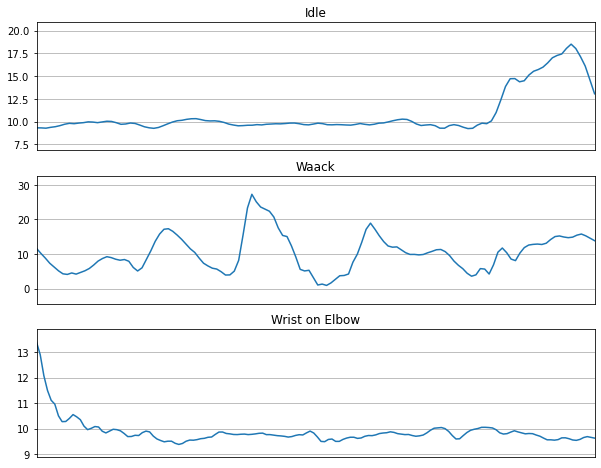

In [140]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(10, 8))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['PacketCounter'], activities[i]['m'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()

plot_activity([idle, waack, wrist_on_elbow],
              ['Idle', 'Waack', 'Wrist on Elbow'])

#### Split training data

In [141]:
X_train, X_test, y_train, y_test = train_test_split(train_df, label_train, test_size = 0.2, random_state = 0)

In [142]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (321, 8)
y_train shape: (321, 6)


In [143]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (81, 8)
y_test shape: (81, 6)


In [144]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = label_train['Label'].iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 300 #400 #200 #300
STEP = 150  #100 #60 #80 #40 #150

X_train, y_train = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

In [145]:
print(X_train.shape, y_train.shape)

(252, 150, 3) (252, 1)


In [146]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [147]:
print(X_train.shape, y_train.shape)

(252, 150, 3) (252, 3)


#### Train the model

In [148]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[0], X_train.shape[1]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [149]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64, #64 #128 #32
    validation_split=0.1,
    shuffle=True
)

Train on 226 samples, validate on 26 samples
Epoch 1/20
226/226 [==============================] - 4s 18ms/sample - loss: 0.8967 - acc: 0.6195 - val_loss: 2.5838 - val_acc: 0.0000e+00
Epoch 2/20
226/226 [==============================] - 1s 6ms/sample - loss: 0.4526 - acc: 0.8407 - val_loss: 3.5294 - val_acc: 0.0000e+00
Epoch 3/20
226/226 [==============================] - 1s 6ms/sample - loss: 0.3131 - acc: 0.9027 - val_loss: 3.7106 - val_acc: 0.0000e+00
Epoch 4/20
226/226 [==============================] - 1s 6ms/sample - loss: 0.1896 - acc: 0.9513 - val_loss: 3.7045 - val_acc: 0.0000e+00
Epoch 5/20
226/226 [==============================] - 1s 6ms/sample - loss: 0.1606 - acc: 0.9558 - val_loss: 3.5097 - val_acc: 0.0000e+00
Epoch 6/20
226/226 [==============================] - 1s 6ms/sample - loss: 0.1013 - acc: 0.9646 - val_loss: 3.4571 - val_acc: 0.0000e+00
Epoch 7/20
226/226 [==============================] - 1s 6ms/sample - loss: 0.0897 - acc: 0.9602 - val_loss: 3.6817 - val_acc:

#### Evaluation

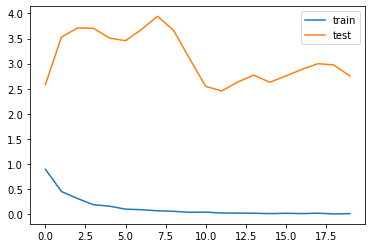

In [150]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

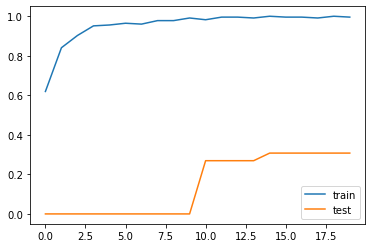

In [151]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

In [152]:
model.evaluate(X_test, y_test)

252/252 [==============================] - 0s 2ms/sample - loss: 0.2899 - acc: 0.9286


[0.28987867162296815, 0.9285714]

In [153]:
model.evaluate(X_train, y_train)

252/252 [==============================] - 0s 2ms/sample - loss: 0.2899 - acc: 0.9286


[0.28987867162296815, 0.9285714]

#### Confusion Matrix

In [154]:
y_pred = model.predict(X_test)

In [155]:
column_names = 'Idle', 'Waack', 'Wrist_on_Elbow'

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(column_names)
  ax.set_yticklabels(column_names)
  b, t = plt.ylim() # discover the values for bottom and top
  #b += 0.5 # Add 0.5 to the bottom
  #t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

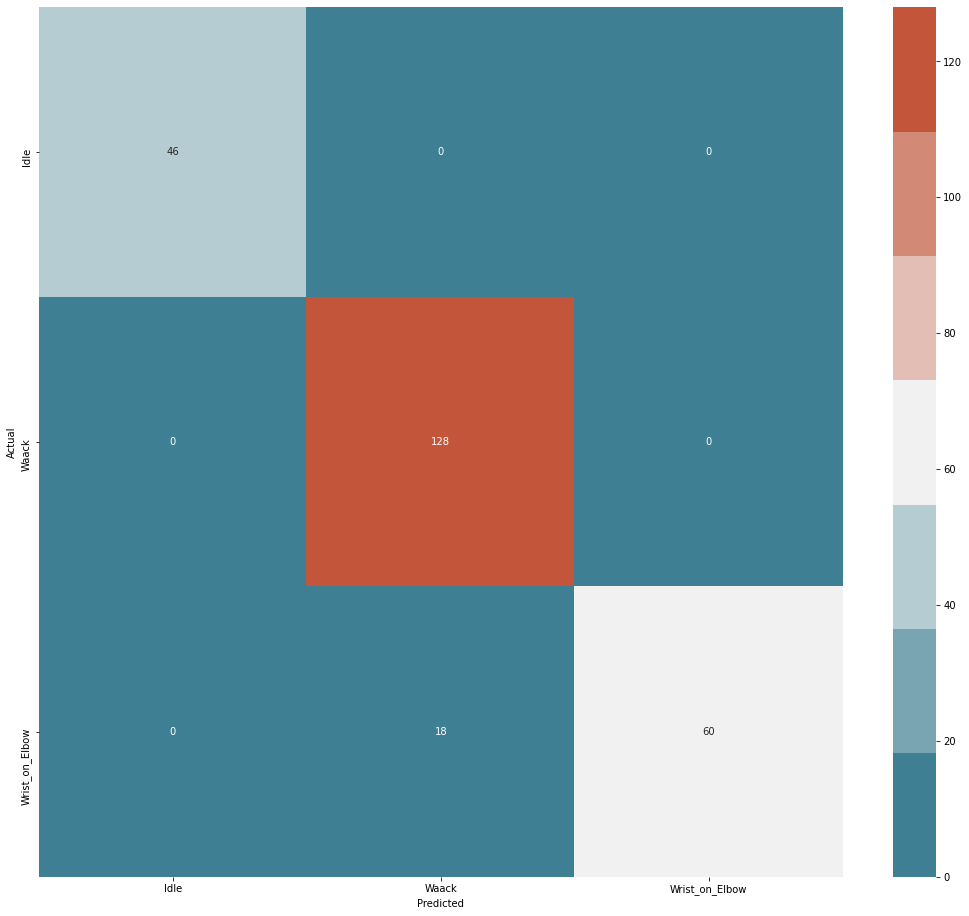

In [156]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)